In [1]:
import numpy as np
import xarray as xr
import dask
from dask.diagnostics import ProgressBar
import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import sys
import os
import glob

from geodatautils import xrutils, cdoutils, helpers

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

# custom modules
#sys.path.insert(0, '/raid/scratch/bkraft/code/packages')
# from geo import geoutils, xrutils, xrmetrics

## Settings

In [2]:
# Time subset # Precipitation limits range to 2012, Uli will update data until 2014.
years_targets = np.arange(2002, 2014+1)
years_features = np.arange(2001, 2014+1)

In [3]:
base_path_source = '/workspace/BGI/'
base_path_target = '/workspace/bkraft/hydrodl/data/processed/'

# FEATURES

### Precipitation

In [4]:
PREC_path = [base_path_source + 'data/DataStructureMDI/DATA/grid/Global/1d00_daily/GPCP/v1_2/'\
             'Data/v6/Precip.GPCP_v1_2.{:4d}.nc'.format(y) for y in years_features]
PREC_out_path = base_path_target + '1d/daily/prec.{:d}_{:d}.nc'.format(years_features[0], years_features[-1])

In [5]:
PREC = xr.open_mfdataset(PREC_path)
PREC.to_netcdf(PREC_out_path)

### Net radiation

In [19]:
RN_path = [base_path_source + 'data/DataStructureMDI/DATA/grid/Global/1d00_daily/CERES/Ed4A/'\
             'Data/Rn/Rn.360.180.{:03d}.{:4d}.nc'.format(366 if y%4==0 else 365, y) for y in years_features]
RN_out_path = base_path_target + '1d/daily/rn.{:d}_{:d}.nc'.format(years_features[0], years_features[-1])

In [9]:
RN = xr.open_mfdataset(RN_path)
RN = RN.rename({'latitude': 'lat', 'longitude': 'lon'})
RN.to_netcdf(RN_out_path)

### Temperature

In [20]:
T_path = [base_path_source + 'data/DataStructureMDI/DATA/grid/Global/0d50_daily/CRUNCEP/v8/'\
             'Data/tair/tair.CRUNCEP.v8.720.360.{:04d}.nc'.format(y) for y in years_features]
T_tmp_path = [base_path_target + '0d5/daily/tair.CRUNCEP.v8.720.360.{:04d}.nc'.format(y) for y in years_features]
T_out_path = base_path_target + '1d/daily/t.{:d}_{:d}.nc'.format(years_features[0], years_features[-1])

In [ ]:
for i, o, year in zip(T_path, T_tmp_path, years_features):
    T = xr.open_dataset(i)
    T = T.rename({'latitude': 'lat', 'longitude': 'lon'})
    T = T.coarsen({'lat': 2, 'lon': 2}).mean()
    if year % 4 == 0:
        # Leap year Feb.29. missing, repeat Feb. 28th where needed
        fill_date = '{:d}-02-29'.format(year) + pd.to_datetime(str(T.time[0].data)).strftime('T%H:%M:%S.%f')
        interp = T.interp(time=[fill_date])
        T = T.merge(interp)
        T.to_netcdf(o)
    else:
        T.to_netcdf(o)

In [61]:
T = xr.open_mfdataset(T_tmp_path)

In [ ]:
T.to_netcdf(T_out_path)

In [ ]:
helpers.rmifexisting(T_tmp_path)

# TARGETS

### TWS

Irregular intervals, gaps

In [48]:
TWS_path = base_path_source + 'data/DataStructureMDI/DATA/grid/Global/0d50_monthly/GRACE/mascons'\
    '/RL06/Data/lwe_thickness.CRI.GRCTellus.JPL.200204_201706.GLO.RL06M_1.MSCNv01CRIv01.nc'
TWS_out_path = base_path_target + '1d/monthly/tws.{:d}_{:d}.nc'.format(years_targets[0], years_targets[-1])

In [16]:
TWS = xr.open_dataset(TWS_path)

In [9]:
TWS = xr.open_dataset(TWS_path)
TWS_orig = xr.open_dataset(TWS_path)
TWS = TWS.coarsen(lon=2, lat=2).mean()
TWS['lwe_thickness'] = TWS.lwe_thickness * 10
TWS = TWS.sel(time=slice('{:d}-01-01'.format(years_targets[0]), '{:d}-12-31'.format(years_targets[-1])))
TWS.attrs = TWS_orig.attrs
TWS.to_netcdf(TWS_out_path)
TWS.close()
TWS_orig.close()

helpers.rmifexisting(TWS_out_path)
TWS.attrs = TWS_orig.attrs
TWS['time'] = TWS_orig['time']
TWS['time_bounds'] = TWS_orig['time_bounds'].astype('datetime64[m]')
TWS = TWS.sel(time=slice('{:d}-01-01'.format(years_targets[0]), '{:d}-12-31'.format(years_targets[-1])))
#TWS.to_netcdf(TWS_out_path)
#TWS.close()
#TWS_orig.close()

### ET
Daily, no missing, aggregate to monthly

In [22]:
ET_paths = [base_path_source + 'work_3/FluxcomDataStructure/EnergyFluxes/RS/ensemble/720_360/monthly/'\
    'LE.RS.EBC-ALL.MLM-ALL.METEO-NONE.720_360.monthly.{:4d}.nc'.format(y) for y in years_targets]
ET_tmp_path = base_path_target + '0d5/monthly/LE.RS.EBC-ALL.MLM-ALL.METEO-NONE.720_360.monthly_tmp.nc'
ET_out_path = base_path_target + '1d/monthly/et.{:d}_{:d}.nc'.format(years_targets[0], years_targets[-1])

In [11]:
ET = xr.open_mfdataset(ET_paths)
ET_new = xr.Dataset(coords={'lat': ET.lat.data, 'lon': ET.lon.data, 'time': ET.time.data})
ET_new['ET'] = ET.LE/2.45
ET_new['ET_mad'] = ET.LE_mad/2.45
ET_new.to_netcdf(ET_tmp_path)
ET_new.close()

In [12]:
ET_new = xr.open_dataset(ET_tmp_path)

In [13]:
ET_new = ET_new.coarsen(lon=2, lat=2).mean()

/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [14]:
month_bounds = np.concatenate((
    pd.date_range(start='{:d}-01-01'.format(years_targets[0]), end='{:d}-12-31'.format(years_targets[-1]), freq='MS').values.reshape(-1, 1),
    pd.date_range(start='{:d}-01-01'.format(years_targets[0]), end='{:d}-12-31'.format(years_targets[-1]), freq='M').values.reshape(-1, 1)), axis=1)
month_bounds = xr.DataArray(month_bounds, coords=[ET_new.time, xr.IndexVariable('bounds', [0, 1])])
ET_new['time_bnds'] = month_bounds
ET_new.to_netcdf(ET_out_path)

In [15]:
helpers.rmifexisting(ET_tmp_path)

### Q

In [75]:
Q_path = '/workspace/bkraft/hydrodl/data/raw/GRUN_v1_GSWP3_WGS84_05_1902_2014.nc'
Q_out_path = base_path_target + '1d/monthly/q.{:d}_{:d}.nc'.format(years_targets[0], years_targets[-1])

In [76]:
Q = xr.open_dataset(Q_path)
Q = Q.sel(time=slice('{:d}-01-01'.format(years_targets[0]), '{:d}-12-31'.format(years_targets[-1])))
Q = Q.coarsen(lon=2, lat=2).mean()

/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [77]:
month_bounds = np.concatenate((
    pd.date_range(start='{:d}-01-01'.format(years_targets[0]), end='{:d}-12-31'.format(years_targets[-1]), freq='MS').values.reshape(-1, 1),
    pd.date_range(start='{:d}-01-01'.format(years_targets[0]), end='{:d}-12-31'.format(years_targets[-1]), freq='M').values.reshape(-1, 1)), axis=1)
month_bounds = xr.DataArray(month_bounds, coords=[Q.time, xr.IndexVariable('bounds', [0, 1])])

In [78]:
Q['time_bnds'] = month_bounds

In [79]:
Q['time'] = Q.time + pd.Timedelta(15, 'D')

In [81]:
Q.to_netcdf(Q_out_path)

### SWE

Daily, missing values.

Enrich SWE using MODIS snow cover (set SWE to 0 where snow cover low)

In [6]:
SWE_paths = [base_path_source + 'data/DataStructureMDI/DATA/grid/Global/0d25_daily/Globsnow_SWE/v2/Data/SWE.1440.720.{:4d}.nc'.format(y) for y in np.append(years_targets[0]-1, years_targets)]
SWE_path = '/workspace/hydrodl/data/raw/swe.{:d}_{:d}.nc'.format(years_targets[0], years_targets[-1])
SWE_gapfilled_path = base_path_target + '1d/daily/swe.{:d}_{:d}.nc'.format(years_targets[0], years_targets[-1])

SCF_paths = [base_path_source + 'data/DataStructureMDI/DATA/grid/Global/1d00_8daily/MODIS/MOD10C2.006/Data/Eight_Day_CMG_Snow_Cover/Eight_Day_CMG_Snow_Cover.360.180.{:4d}.nc'.format(y) for y in np.append(years_targets[0]-1, years_targets)]
SCF_path = base_path_target + '1d/8daily/snow_cover.{:d}_{:d}.nc'.format(years_targets[0], years_targets[-1])

### Stack SCF

In [7]:
scf = xr.open_mfdataset(SCF_paths)
scf = scf.rename({'Eight_Day_CMG_Snow_Cover': 'val', 'latitude': 'lat', 'longitude': 'lon'})
scf.to_netcdf(SCF_path)

### Stack SWE

In [8]:
swe_stack = []
for p in SWE_paths:
    d = xr.open_dataset(p).drop('SWE_var').rename({'SWE': 'val'})
    d = d.where(d.val!=-2, np.nan)
    d = d.where(d.val!=-1, np.nan)
    d = d.coarsen(lat=4, lon=4).mean()
    swe_stack.append(d)

/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  re

In [9]:
swe = xr.concat(swe_stack, dim='time')

In [10]:
swe.to_netcdf(SWE_path)

### SCF pixel-timesteps where mean over 24 days is < threshold

In [11]:
scf = xr.open_dataset(SCF_path)

In [12]:
scf_threshold = 10

In [13]:
scf_red = scf.rolling(time=3, min_periods=3, center=True).mean()

/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [14]:
fill_slice = scf_red.isel(time=0)

In [15]:
fill_slice['time'] = [np.datetime64('{}-12-31'.format(years_targets[-1]))]

In [16]:
scf_red = scf_red.merge(fill_slice)

In [17]:
scf_red

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 643)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-01-09 ... 2014-12-31
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
Data variables:
    val      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [18]:
scf_red_mask = scf_red < scf_threshold

/opt/conda/lib/python3.6/site-packages/geodatautils/xrutils.py:396: MatplotlibDeprecationWarning: 
The get_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.get_clim instead.
  clims = p.colorbar.get_clim()
/opt/conda/lib/python3.6/site-packages/geodatautils/xrutils.py:399: MatplotlibDeprecationWarning: 
The get_cmap function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.get_cmap instead.
  cm = p.colorbar.get_cmap()
/opt/conda/lib/python3.6/site-packages/geodatautils/xrutils.py:407: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax1_inset.hist(data, np.linspace(*clims, hist_bins), normed=1, color='green')
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/opt/conda/lib/python3.6/site-packages/geo

(<matplotlib.collections.QuadMesh at 0x7f3139ca3e48>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f3144038588>)

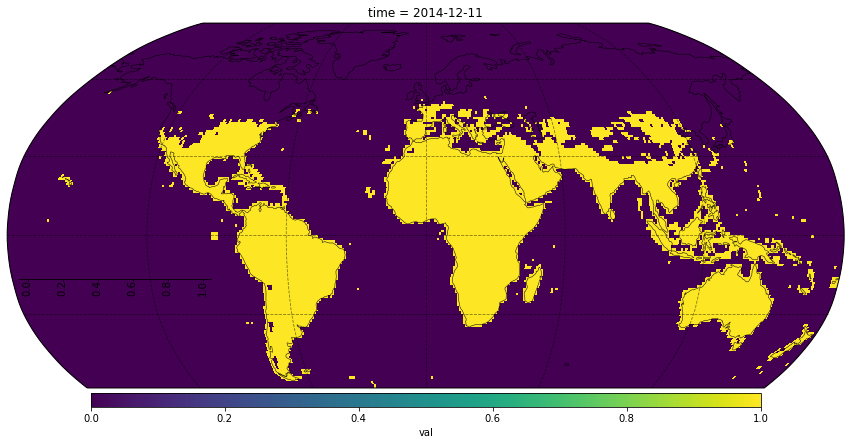

In [19]:
xrutils.plot_map(scf_red_mask.val.isel(time=-4), title=None)

In [20]:
scf_red_mask_1d = scf_red_mask.resample(time='1D').nearest(tolerance='4D').sel(time=slice('{}-01-01'.format(years_targets[0]), None))

In [21]:
scf_red_mask_1d

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 4748)
Coordinates:
  * time     (time) datetime64[ns] 2002-01-01 2002-01-02 ... 2014-12-31
  * lat      (lat) float64 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    val      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

/opt/conda/lib/python3.6/site-packages/geodatautils/xrutils.py:396: MatplotlibDeprecationWarning: 
The get_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.get_clim instead.
  clims = p.colorbar.get_clim()
/opt/conda/lib/python3.6/site-packages/geodatautils/xrutils.py:399: MatplotlibDeprecationWarning: 
The get_cmap function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.get_cmap instead.
  cm = p.colorbar.get_cmap()
/opt/conda/lib/python3.6/site-packages/geodatautils/xrutils.py:407: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax1_inset.hist(data, np.linspace(*clims, hist_bins), normed=1, color='green')
/opt/conda/lib/python3.6/site-packages/geodatautils/xrutils.py:459: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead

(<matplotlib.collections.QuadMesh at 0x7f3139991b00>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f3139be2d68>)

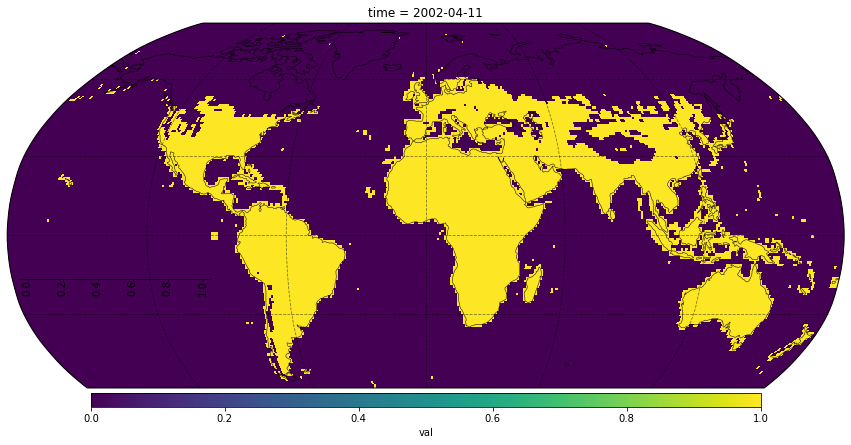

In [22]:
xrutils.plot_map(scf_red_mask_1d.val.isel(time=100), title=None)

### SWE pixel-time-steps where 24 consecutive days have missign values.

In [23]:
swe = xr.open_dataset(SWE_path)

In [24]:
swe_missing = swe.isnull()

In [25]:
swe_num_missing = swe_missing.rolling(time=24).sum().sel(time=slice('{}-01-01'.format(years_targets[0]), None))

In [26]:
swe_num_missing_mask = swe_num_missing == 24

/opt/conda/lib/python3.6/site-packages/geodatautils/xrutils.py:396: MatplotlibDeprecationWarning: 
The get_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.get_clim instead.
  clims = p.colorbar.get_clim()
/opt/conda/lib/python3.6/site-packages/geodatautils/xrutils.py:399: MatplotlibDeprecationWarning: 
The get_cmap function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.get_cmap instead.
  cm = p.colorbar.get_cmap()
/opt/conda/lib/python3.6/site-packages/geodatautils/xrutils.py:407: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax1_inset.hist(data, np.linspace(*clims, hist_bins), normed=1, color='green')
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/opt/conda/lib/python3.6/site-packages/geo

(<matplotlib.collections.QuadMesh at 0x7f31440589e8>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f31398a4ef0>)

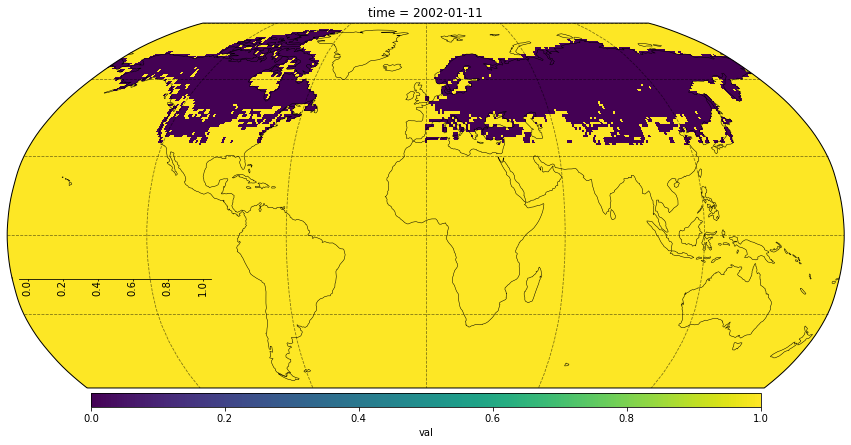

In [27]:
xrutils.plot_map(swe_num_missing_mask.val.isel(time=10), title=None)

### Combine masks

In [28]:
scf_red_mask_1d['time'] = swe_num_missing_mask.time

In [29]:
fill_mask = scf_red_mask_1d.val * swe_num_missing_mask.val.astype(np.float)

/opt/conda/lib/python3.6/site-packages/geodatautils/xrutils.py:396: MatplotlibDeprecationWarning: 
The get_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.get_clim instead.
  clims = p.colorbar.get_clim()
/opt/conda/lib/python3.6/site-packages/geodatautils/xrutils.py:399: MatplotlibDeprecationWarning: 
The get_cmap function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.get_cmap instead.
  cm = p.colorbar.get_cmap()
/opt/conda/lib/python3.6/site-packages/geodatautils/xrutils.py:407: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax1_inset.hist(data, np.linspace(*clims, hist_bins), normed=1, color='green')
/opt/conda/lib/python3.6/site-packages/geodatautils/xrutils.py:459: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead

(<matplotlib.collections.QuadMesh at 0x7f3139609748>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f3139a20860>)

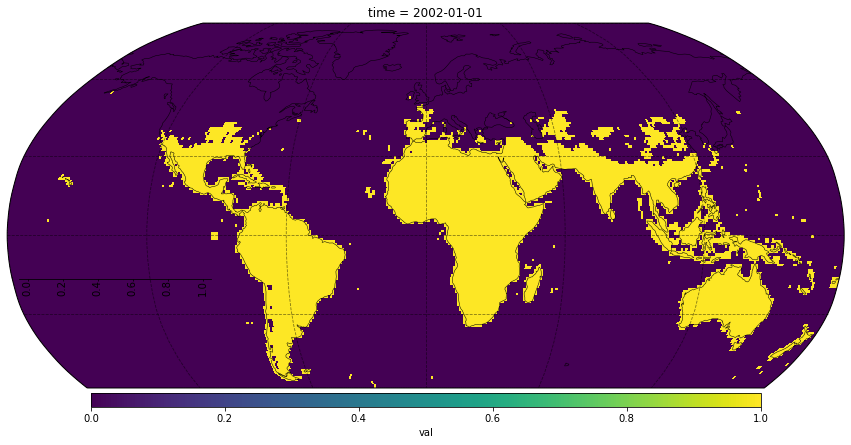

In [30]:
xrutils.plot_map(fill_mask.isel(time=0), title=None)

### Fill SWE

In [31]:
swe_timesubs = swe.sel(time=slice('{}-01-01'.format(years_targets[0]), None))

In [32]:
swe_gapfiled = swe_timesubs.where(1-fill_mask, 0)

In [33]:
scf_land_mask = scf.val.notnull().any('time')

In [34]:
swe_gapfiled = swe_gapfiled.where(scf_land_mask, np.nan)

/opt/conda/lib/python3.6/site-packages/geodatautils/xrutils.py:396: MatplotlibDeprecationWarning: 
The get_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.get_clim instead.
  clims = p.colorbar.get_clim()
/opt/conda/lib/python3.6/site-packages/geodatautils/xrutils.py:399: MatplotlibDeprecationWarning: 
The get_cmap function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.get_cmap instead.
  cm = p.colorbar.get_cmap()
/opt/conda/lib/python3.6/site-packages/geodatautils/xrutils.py:407: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax1_inset.hist(data, np.linspace(*clims, hist_bins), normed=1, color='green')
/opt/conda/lib/python3.6/site-packages/geodatautils/xrutils.py:459: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead

(<matplotlib.collections.QuadMesh at 0x7f3139460c18>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f3139435240>)

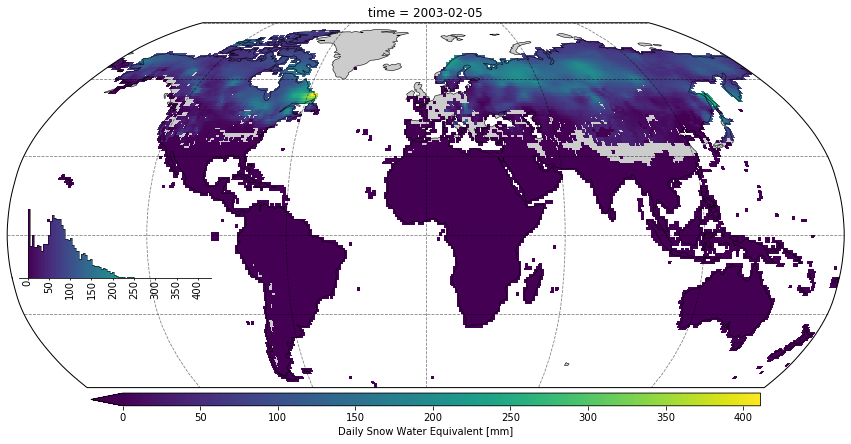

In [35]:
xrutils.plot_map(swe_gapfiled.val.isel(time=400), title=None, vmin=0)

In [36]:
swe_gapfiled.to_netcdf(SWE_gapfilled_path)

# Static variables

### DHM

In [4]:
file_in = '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d0083_static/GTOPO30/not_defined/Data/GTOPO30.43200.21600.nc'
dhm_path = base_path_target + '0d0083/gtopo_dem.nc'

In [11]:
dhm = xr.open_dataset(file_in)

In [12]:
dhm = dhm.rename({'GTOPO30': 'data'})

In [13]:
dhm = dhm.coarsen({'lat': 4, 'lon': 4}).mean()

/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [14]:
dhm['data'] = dhm.data.expand_dims('var', 0)

In [15]:
dhm['var'] = ['dem']

In [16]:
dhm.to_netcdf('/workspace/hydrodl/data/raw/landmask.nc')

In [14]:
dhm = dhm.where(~dhm.data.isnull(), 0)

In [15]:
dhm.to_netcdf(dhm_path)

### Soilgrids

In [4]:
files_in = glob.glob('/workspace/hydrodl/data/raw/soilgrids_1km/*.tif')
soilgrids_path = base_path_target + '0d0083/soilgrids.nc'
files_out = [soilgrids_path.replace('.nc', '_{:03d}.nc'.format(i)) for i in range(len(files_in))]

with open('/workspace/hydrodl/data/raw/soilgrids_1km/variables.txt') as f:
    var = f.read()

for v in var.split(','):
    !wget -P '/workspace/hydrodl/data/raw/soilgrids_1km/' {'https://files.isric.org/soilgrids/data/aggregated/1km/' + v + '.tif'}

In [34]:
stack = []
stack_names = []
for i, (file_in, file_out) in enumerate(zip(files_in, files_out)):
    clear_output(wait=True)
    lat = np.linspace(90-1/24, -90+1/24, num=180*120)
    name = os.path.basename(file_in).split('.')[0]
    print('{:3d} / {:3d}: {}'.format(i+1, len(files_in), name), flush=True)
    
    d = xr.open_rasterio(file_in).isel(band=0).drop('band')
    nodatavals = d.attrs['nodatavals']
    d = d.astype('float32')
    d.values[np.isin(d, nodatavals)] = np.nan
    d = d.rename({'x': 'lon', 'y': 'lat'})
    d = d.interp(coords={'lat': lat}, method='nearest', kwargs={'fill_value': np.nan})
    d = d.coarsen({'lat': 4, 'lon': 4}).mean()
    d.name = name
    d = d.where(d.notnull(), 0)

    stack.append(d)
    stack_names.append(name)

 36 /  36: CLYPPT_M_sl4_1km_ll


In [74]:
stacked = xr.Dataset()
stacked['data'] = xr.concat(stack, dim='var')
stacked['var'] = stack_names

In [76]:
stacked.to_netcdf(soilgrids_path)

### MCD12Q1

In [26]:
file_in = '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d0083_static/MCD12Q1/V005/Data/v005_2/MCD12Q1plusC4_fraction.GLOBAL01KM.2001001.LC.01KM.nc'
mcd_path = base_path_target + '0d0083/mdc12q1.nc'

In [29]:
mcd = xr.open_dataset(file_in)

In [30]:
mcd = mcd.rename({'MCD12Q1plusC4_fraction': 'data', 'longitude': 'lon', 'latitude': 'lat'})

In [31]:
mcd['classes'] = np.array([l[1][1:].decode("utf-8").replace(' ', '_').lower() for l in mcd.Legend.values])[:-2]

In [32]:
mcd = mcd.drop('Legend')

In [33]:
mcd = mcd.coarsen({'lat': 4, 'lon': 4}).mean()

In [34]:
mcd['data'] = mcd.data.expand_dims('var', 0)

In [35]:
mcd['var'] = ['cl']

In [37]:
mcd = mcd.where(~mcd.data.isnull(), 0)

In [38]:
mcd.to_netcdf(mcd_path)

## Mask
* No missing in features
* Not more than 50% missing in target
* Tina's mask of regions where human impact large

### Features

In [ ]:
T = xr.open_dataset(T_out_path)
T_mask = T.tair.notnull().all('time')
P = xr.open_dataset(PREC_out_path)
P_mask = P.Precip.notnull().all('time')
RN = xr.open_dataset(RN_out_path)
RN_mask = RN.Rn.notnull().all('time')

features_mask = T_mask*P_mask*RN_mask

### Targets

In [179]:
TWS = xr.open_dataset(TWS_out_path)
TWS_mask = TWS.lwe_thickness.count('time') / len(TWS.time) > 0.5
ET = xr.open_dataset(ET_out_path)
ET_mask = ET.ET.count('time') / len(ET.time) > 0.5
SWE = xr.open_dataset(SWE_gapfilled_path)
SWE_mask = SWE.val.count('time') / len(SWE.time) > 0.5
Q = xr.open_dataset(Q_out_path)
Q_mask = Q.Runoff.count('time') / len(Q.time) > 0.5

target_mask = TWS_mask * ET_mask * SWE_mask * Q_mask

### Human impact

In [180]:
human_mask = xr.open_rasterio('/workspace/bkraft/01_hydro_dl/data/1d/static/noDirectHuman.tif')
human_mask = human_mask==human_mask.nodatavals
human_mask = human_mask.rename({'y': 'lat', 'x': 'lon'}).isel(band=0)

### Combine all masks

In [181]:
mask = features_mask * target_mask * human_mask
mask = xr.Dataset({'mask': mask})

In [188]:
def stripes_like(xr_array, num_stripes):
    """Creates diagonally striped xr.DataArray, with repeated stribes
    from 1-``num_stripes``."""
    x = np.zeros_like(xr_array.data, dtype=int)
    i, j = np.indices(xr_array.data.shape)
    for s in range(num_stripes):
        x[(i+s)%num_stripes==j%num_stripes] = s+1
    striped = xr.zeros_like(xr_array, dtype=int)
    striped.data = x
    return striped

In [189]:
mask_striped = (stripes_like(mask.mask, 5) * mask).compute()

In [191]:
mask_striped.to_netcdf(base_path_target + '1d/static/mask.nc')

(<matplotlib.collections.QuadMesh at 0x7f32c841c940>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f32cca7e710>)

<Figure size 1440x720 with 0 Axes>

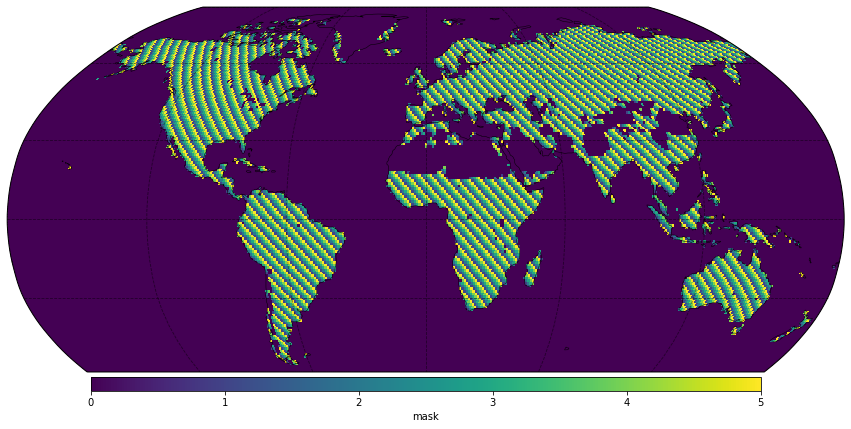

In [192]:
plt.figure(figsize=(20, 10))
xrutils.plot_map(mask_striped.mask, add_hist=False)

# Create data bucket

In [2]:
from bucket import SpatialData, SampleFormatter, Bucket
from torch.utils.data import DataLoader
import numpy as np

In [40]:
mask = SpatialData('/workspace/bkraft/01_hydro_dl/data/1d/static/mask.nc',
                   varname='mask', varname_new='land_mask', hastime=False, dtype=np.int8)

In [41]:
t = Bucket('/workspace/work_2/bucket.zarr/',
           nlat=180, nlon=360, mask=mask,
           overwrite=True, chunk_size=10,
           sample_formater_path='/workspace/hydrodl/models/hybrid/hydrodl_config.json')

In [42]:
tair = SpatialData('/workspace/bkraft/hydrodl/data/processed/1d/daily/t.2001_2014.nc',
               varname='tair', varname_new='tair')
rn = SpatialData('/workspace/bkraft/hydrodl/data/processed/1d/daily/rn.2001_2014.nc',
               varname='Rn', varname_new='rn')
prec = SpatialData('/workspace/bkraft/hydrodl/data/processed/1d/daily/prec.2001_2014.nc',
               varname='Precip', varname_new='prec')

In [46]:
soilgrids = SpatialData('/workspace/hydrodl/data/processed/0d0083/soilgrids.nc', varname='data', varname_new='soilgrids', hastime=False)
mcd = SpatialData('/workspace/hydrodl/data/processed/0d0083/mdc12q1.nc', varname='data', varname_new='mcd', hastime=False)
dem = SpatialData('/workspace/hydrodl/data/processed/0d0083/gtopo_dem.nc', varname='data', varname_new='dem', hastime=False)

In [52]:
et = SpatialData('/workspace/bkraft/hydrodl/data/processed/1d/monthly/et.2002_2014.nc',
               varname='ET', varname_new='et', hastimebin=True, timebinname='time_bnds', istarget=True)
swe = SpatialData('/workspace/bkraft/hydrodl/data/processed/1d/daily/swe.2002_2014.nc',
               varname='val', varname_new='swe', istarget=True)
tws = SpatialData('/workspace/bkraft/hydrodl/data/processed/1d/monthly/tws.2002_2014.nc',
               varname='lwe_thickness', varname_new='tws', hastimebin=True, timebinname='time_bounds', istarget=True)
q = SpatialData('/workspace/bkraft/hydrodl/data/processed/1d/monthly/q.2002_2014.nc',
               varname='Runoff', varname_new='q', hastimebin=True, timebinname='time_bnds', istarget=True)

In [ ]:
t.add(soilgrids, mcd, dem, tair, rn, prec, et, swe, tws, q)

In [10]:
cv_folds = []
for i in range(5):
    cv_indices = dict(
            cvidx_train=(np.array([0, 1, 2]) + i) % 5 + 1,
            cvidx_valid=(np.array([3]) + i) % 5 + 1,
            cvidx_test=(np.array([4]) + i) % 5 + 1
    )
    cv_folds.append(cv_indices)
cv_folds

[{'cvidx_train': array([1, 2, 3]),
  'cvidx_valid': array([4]),
  'cvidx_test': array([5])},
 {'cvidx_train': array([2, 3, 4]),
  'cvidx_valid': array([5]),
  'cvidx_test': array([1])},
 {'cvidx_train': array([3, 4, 5]),
  'cvidx_valid': array([1]),
  'cvidx_test': array([2])},
 {'cvidx_train': array([4, 5, 1]),
  'cvidx_valid': array([2]),
  'cvidx_test': array([3])},
 {'cvidx_train': array([5, 1, 2]),
  'cvidx_valid': array([3]),
  'cvidx_test': array([4])}]

In [13]:
with open('/workspace/hydrodl/experiments/test/test/summary/best_params.pkl', 'rb') as f:
    params = pickle.load(f)

In [15]:
params

{'static_hidden_size': 0.0,
 'static_num_layers': 0.0,
 'static_enc_size': 0.0,
 'tcn_channel_size': 7.0,
 'tcn_num_layers': 4.0,
 'tcn_kernel_size': 6.0,
 'shared_hidden_size': 24.0,
 'shared_num_layers': 3.0,
 'task_hidden_size': 16.0,
 'task_num_layers': 2.0,
 'dropout': 0.7000000000000001,
 'num_spinup_years': 10,
 'learning_rate': 0.0001,
 'weight_decay': 0,
 'task_weighting': False}

In [6]:
import matplotlib.pyplot as plt

In [ ]:
ds_m =  ds.var.where(mask, np.nan)

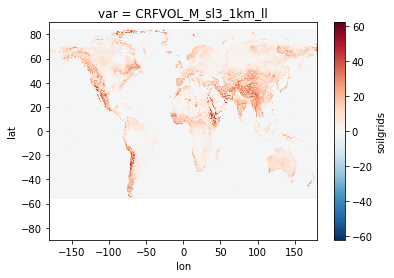

In [22]:
ds.var.isel(var=0).plot()

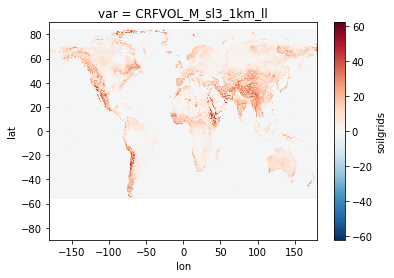

In [22]:
ds_m.var.isel(var=0).plot()

In [5]:
mask = self.getvar('mask')[:] > 0
# Expand mask to match ds lat x lon.
mask = mask.repeat(scale_factor, axis=0).repeat(scale_factor, axis=1)

In [7]:
# def _set_mean_std(self, ds, scale_factor):
self = t
ds = soilgrids
scale_factor = 12


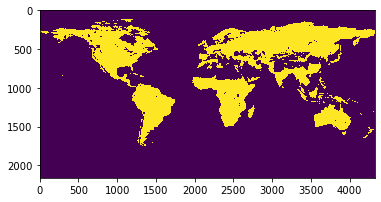

In [13]:
plt.imshow(m_b[1, :, :])

In [8]:
ds.var.ndim

3

In [29]:
# def _set_mean_std(self, ds, scale_factor):
self = t
ds = soilgrids
scale_factor = 12
"""Add mean and std to Bucket array as attributes.

Args:
    ds: Dataset of type SpatialData.
    scale_factor: Dataset scale factor.
"""

mask = self.getvar('mask')[:] > 0
# Expand mask to match ds lat x lon.
mask = mask.repeat(scale_factor, axis=0).repeat(scale_factor, axis=1)
# Get values where mask.
if ds.hastime:
    # Expand dimensions to match ds dims.
    mask = np.broadcast_to(mask, (*ds.var.shape,))
    values = ds.var.data[np.where(mask)]
    mean = self._json_encoder(np.nanmean(values))
    std = self._json_encoder(np.nanstd(values))
elif (not ds.hastime) and ds.var.ndim == 3:
    mean = []
    std = []
    for i in range(ds.var.shape[0]):
        values = ds.var.data[i][np.where(mask)]
        mean.append(self._json_encoder(np.nanmean(values)))
        std.append(self._json_encoder(np.nanstd(values)))
else:
    raise ValueError('Dataset must have 3 dimensions if it has no time diension, but has {}.'.format(ds.var.ndim))

attrs_new = {
    'mean': mean,
    'std': std
}

[8.338593482971191, 1329.186767578125, 13.019246101379395, 1069.510986328125, 44.31244659423828, 44.20904541015625, 21.25697898864746, 23.225521087646484, 29.92437171936035, 27.373933792114258, 23.850852966308594, 19.678964614868164, 28.336994171142578, 11.973525047302246, 1197.59423828125, 7.76381254196167, 1347.5103759765625, 43.69346618652344, 45.29477310180664, 29.01499366760254, 27.154287338256836, 19.51840591430664, 3049.028076171875, 24.10613250732422, 45.140220642089844, 43.106773376464844, 7.883980751037598, 1263.6214599609375, 10.735201835632324, 43.224647521972656, 9.549283981323242, 1069.479248046875, 1314.3260498046875, 27.04310417175293, 29.609539031982422, 23.023977279663086]


In [30]:
attrs_new

{'mean': [8.338593482971191,
  1329.186767578125,
  13.019246101379395,
  1069.510986328125,
  44.31244659423828,
  44.20904541015625,
  21.25697898864746,
  23.225521087646484,
  29.92437171936035,
  27.373933792114258,
  23.850852966308594,
  19.678964614868164,
  28.336994171142578,
  11.973525047302246,
  1197.59423828125,
  7.76381254196167,
  1347.5103759765625,
  43.69346618652344,
  45.29477310180664,
  29.01499366760254,
  27.154287338256836,
  19.51840591430664,
  3049.028076171875,
  24.10613250732422,
  45.140220642089844,
  43.106773376464844,
  7.883980751037598,
  1263.6214599609375,
  10.735201835632324,
  43.224647521972656,
  9.549283981323242,
  1069.479248046875,
  1314.3260498046875,
  27.04310417175293,
  29.609539031982422,
  23.023977279663086],
 'std': [7.260218620300293,
  358.4303894042969,
  9.155757904052734,
  362.7764892578125,
  16.58527183532715,
  15.830262184143066,
  9.343255996704102,
  11.367891311645508,
  13.549642562866211,
  12.46104907989502,


In [19]:
np.shape(std)

(36,)

In [24]:
ds.var.shape

(132, 180, 360)

In [13]:
ds.var.data[0].shape

(2160, 4320)

In [ ]:
_set_mean_std(t, soilgrids, 12)

In [9]:
from bucket import SpatialData, SampleFormatter, Bucket
from torch.utils.data import DataLoader
import numpy as np
from geodatautils import xrutils, cdoutils, helpers
soilgrids = SpatialData('/workspace/hydrodl/data/processed/0d083/soilgrids_small.nc', varname='data', varname_new='soilgrids', hastime=False)
mask = SpatialData('/workspace/bkraft/01_hydro_dl/data/1d/static/mask.nc',
                   varname='mask', varname_new='land_mask', hastime=False, dtype=np.int8)
t = Bucket('/workspace/work_2/bucket.zarr/',
           nlat=180, nlon=360, mask=mask,
           overwrite=True, chunk_size=10,
           sample_formater_path='/workspace/hydrodl/models/test_model/test_config_sweonly.json')
t.add(soilgrids)

Bucket @ /workspace/work_2/bucket.zarr/
------------------------------------------
chunk_size: 10
nlat: 180
nlon: 360
data:
  - mask:      scale:  1, hastime: False, hastimebin: False
  - soilgrids: scale: 12, hastime: False, hastimebin: False

In [28]:
t.set_space_ids(0, 0, 0)

In [29]:
t_t = t.get_sampler('train')

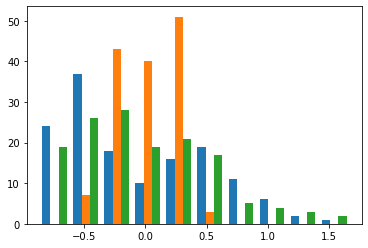

In [30]:
plt.hist(t_t.read_data(90, 100)['static'].reshape(-1, 3));

In [10]:
t.sample_formatter

{
    "_instructions": "1) 'description': Short desrtiption of the configuration. 2) 'stacks': Dataset stacks, each containing  data that has same resolution and same treatment (e.g. feature, targets). 3) 'time-slices': time slices defining train, validate and test set time-spans. 4) 'num_warmup': Number of warmup steps to use, the 'time_slice' get expanded 'warmup' steps into the past (e.g. '1Y' for 1 year, '50D' for 50 days.).",
    "description": "Test config.",
    "stacks": {
        "static": {
            "convolution": true,
            "datasets": [
                "soilgrids"
            ],
            "hastime": false,
            "hastimebin": false,
            "istarget": false
        }
    },
    "time_slices": {
        "test": [
            "2008-01-01",
            "2012-12-31"
        ],
        "train": [
            "2001-01-01",
            "2009-12-31"
        ],
        "validate": [
            "2008-01-01",
            "2012-12-31"
        ]
    },
    "warmu

In [2]:
soilgrids.var.ndim

3

In [4]:
(not ds.hastime) and ds.var.ndim == 3

True

In [7]:
mask.varname

'mask'

In [4]:
t.get_mean_std('soilgrids')

([8.338593482971191, 1329.186767578125, 13.019246101379395],
 [7.260218620300293, 358.4303894042969, 9.155757904052734])

In [6]:
# from bucket import SpatialData, SampleFormatter, Bucket
from torch.utils.data import DataLoader
import numpy as np

In [7]:
t.add(et)

Bucket @ /workspace/work_2/bucket.zarr/
------------------------------------------
chunk_size: 10
nlat: 180
nlon: 360
data:
  - mask:      scale:  1, hastime: False, hastimebin: False
  - soilgrids: scale: 12, hastime: False, hastimebin: False
  - et:        scale:  1, hastime: True , hastimebin: True 

In [6]:
mask = SpatialData('/workspace/bkraft/01_hydro_dl/data/1d/static/mask.nc',
                   varname='mask', varname_new='land_mask', hastime=False, dtype=np.int8)
tair = SpatialData('/workspace/bkraft/01_hydro_dl/data/1d/daily/t.2001_2012.nc',
               varname='tair', varname_new='tair')
rn = SpatialData('/workspace/bkraft/01_hydro_dl/data/1d/daily/rn.2001_2012.nc',
               varname='Rn', varname_new='rn')
prec = SpatialData('/workspace/bkraft/01_hydro_dl/data/1d/daily/prec.2001_2012.nc',
               varname='Precip', varname_new='prec')
et = SpatialData('/workspace/bkraft/01_hydro_dl/data/1d/monthly/et.2002_2012.nc',
               varname='ET', varname_new='et', hastimebin=True, timebinname='time_bnds', istarget=True)
swe = SpatialData('/workspace/bkraft/01_hydro_dl/data/1d/daily/swe.2002_2012.nc',
               varname='val', varname_new='swe', istarget=True)
tws = SpatialData('/workspace/bkraft/01_hydro_dl/data/1d/monthly/tws.2002_2012.nc',
               varname='lwe_thickness', varname_new='lwe', hastimebin=True, timebinname='time_bounds', istarget=True)
# t.add(tair, rn, prec, et, swe, tws)

In [9]:
t.get_mean_std('soilgrids')

([8.338593482971191, 1329.186767578125, 13.019246101379395],
 [7.260218620300293, 358.4303894042969, 9.155757904052734])

In [15]:
s = t.getvar('soilgrids')[..., 1, 2]

In [ ]:
(t.getvar('soilgrids')[..., 1, 2]/t.get_mean_std('soilgrids')[0]).shape

In [16]:
s

array([[[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, 

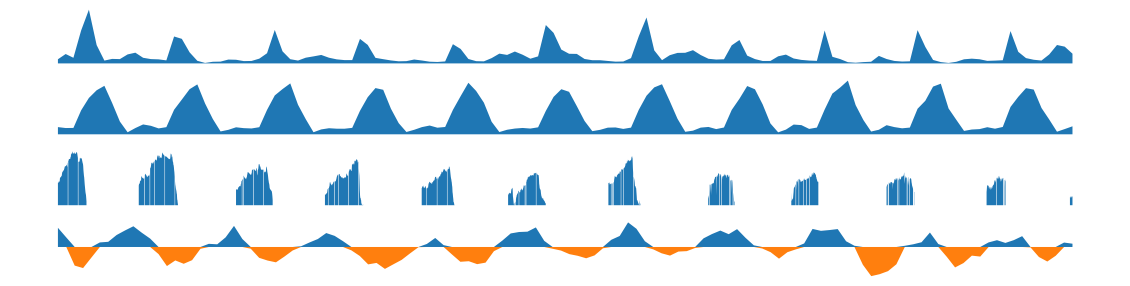

In [96]:
fig, axes = plt.subplots(4, 1, figsize=(20, 5))

for i, d in enumerate([q, et, swe, tws]):
    
    ax = axes.flat[i]
    
    l = d.var.sel(lat=60, lon=50, method='nearest')

    l_p = l.copy()
    l_p[l_p<0] = 0
    l_n = l.copy()
    l_n[l_n>0] = 0
    ax.fill_between(np.arange(len(l)), np.repeat(0, len(l)), l_p)
    ax.fill_between(np.arange(len(l)), np.repeat(0, len(l)), l_n)

    # fig.patch.set_visible(False)
    ax.axis('off')

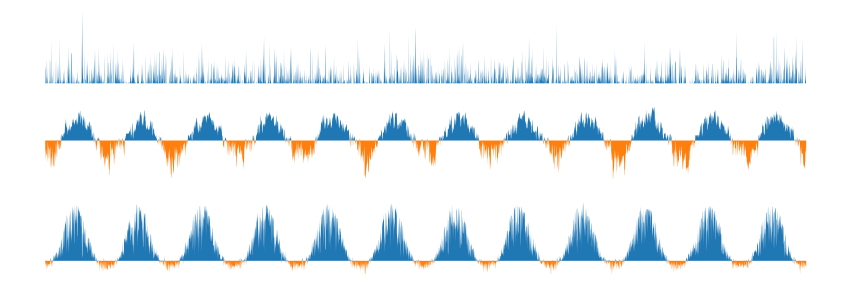

In [100]:
fig, axes = plt.subplots(3, 1, figsize=(15, 5))

for i, d in enumerate([prec, tair, rn]):
    
    ax = axes.flat[i]
    
    l = d.var.sel(lat=60, lon=50, method='nearest')

    if i == 1:
        l -= 273.15
    
    l_p = l.copy()
    l_p[l_p<0] = 0
    l_n = l.copy()
    l_n[l_n>0] = 0
    ax.fill_between(np.arange(len(l)), np.repeat(0, len(l)), l_p)
    ax.fill_between(np.arange(len(l)), np.repeat(0, len(l)), l_n)

    # fig.patch.set_visible(False)
    ax.axis('off')

In [98]:
tair.var 

<xarray.DataArray 'tair' (time: 4383, lat: 180, lon: 360)>
[284018400 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * time     (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2012-12-31
Attributes:
    long_name:  mean 6hourly Temperature
    units:      K

(0.0, 1.0, 0.0, 3.0)

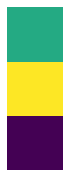

In [125]:
fif, axes = plt.subplots(figsize=(1, 3))
axes.pcolor(np.random.normal(size=(3, 1)))
axes.axis('off')